# Importing essential libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from copy import deepcopy


from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras

# Read Data

This dataset gives 27,305 images of faces, with annotations of their age, ethnicity and gender.

In [2]:
# Install the Kaggle library
! pip install kaggle

In [14]:
from google.colab import files
files.upload()                     # upload [kaggle.json]

In [4]:
# Make a folder named “.kaggle”
! mkdir ~/.kaggle

In [5]:
# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [6]:
# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# the Dataset from kaggle.
! kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 68% 43.0M/63.2M [00:00<00:00, 116MB/s]
100% 63.2M/63.2M [00:00<00:00, 156MB/s]


In [9]:
# Mount Drive:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
# Unzip the Dataset zip file:
! unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [48]:
# Loading a dataset:
df = pd.read_csv('age_gender.csv')

In [49]:
# Show shape:
df.shape

(23705, 5)

The dataset has the data:

* **Age**: the age of a person, between 0 and 116 years
* **Ethnicity**: ethnicity, classified into 5 groups (from 0 to 4)
* **Gender**: the gender, classified between 

    **0** --> **Male**
    
    **1** --> **Female**
    
* The **name** of the original image
* A list of 2304 digits between 0 and 255, corresponding to **pixels** of a 48x48 image

In [50]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


# Analyzing and cleaning the data

Check **Null** Values:

In [51]:
df.isnull().sum()            # as shown the data is clean

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [52]:
y = df[['ethnicity']]

Display **Description** of data:

In [53]:
y.describe()

,ethnicity
count,23705.000000
mean,1.269226
std,1.345638
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


# Label the 5 categories

Ethnicity labels, 0 for ***American-European*** , 1 for ***negro(Black)*** , 2 for ***Japanese*** , 3 for ***Indian*** & 4 for ***Latina***

In [54]:
label_ethnicity = [ 'American-European', 'negro(Black)', 'Japanese', 'Indian', 'Latina']
num_ethnicity = 5
labels=list(range(num_ethnicity))

### Data Distribution

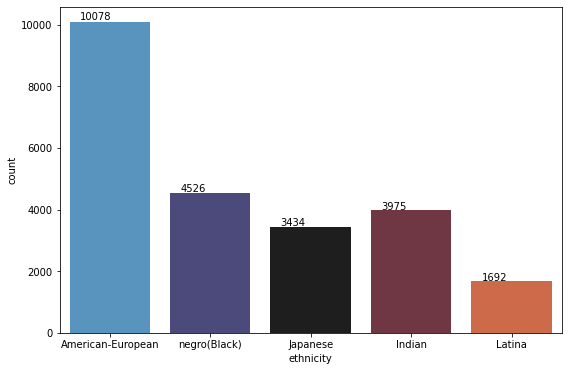

In [56]:
plt.figure( figsize = [9,6] )
ax= sns.countplot(x= y['ethnicity'], palette="icefire")

plt.xticks(ticks=labels,labels=label_ethnicity)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01*p.get_height()))

plt.show()

## As above shows, the distribution of classes is unbalanced, so we should sampling them based on the lowest class which is **Latina**

## ***Sampling***

In [57]:
# sampling:
df=df.groupby('ethnicity').sample(1692,random_state=42)
df=df.sort_index()
y=df[['ethnicity']]

### show **after** sampling:

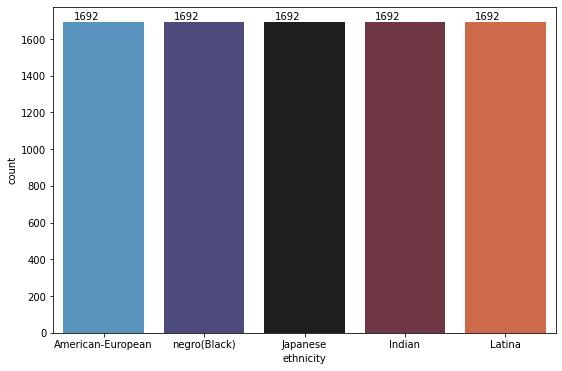

In [60]:
plt.figure(figsize = [9,6])
ax = sns.countplot(x= y['ethnicity'], palette="icefire")
plt.xticks(ticks=labels, labels=label_ethnicity)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01*p.get_height()))

plt.show()

## Expanding the pixels

We take for the **input data of the neural network** the pixels, like a **array 48x48**

In [61]:
X = df['pixels'].str.split(' ', expand=True)
X = np.array(X).astype(int)
X = np.array([a.reshape(48, 48) for a in X])

## Image shape

In [62]:
X.shape

(8460, 48, 48)

## ***Normalize*** pixel data

In [63]:
X = X / 255

Separation of train, validation and test datasets

In [64]:
X_train, X_temp, y_train, y_temp = train_test_split(np.array(X), y, test_size=0.2,random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5,random_state=42)
X_temp, y_temp=[],[]       # Empty those variables

## Display classes distribution in ***Train***, ***Validation*** & ***Test***

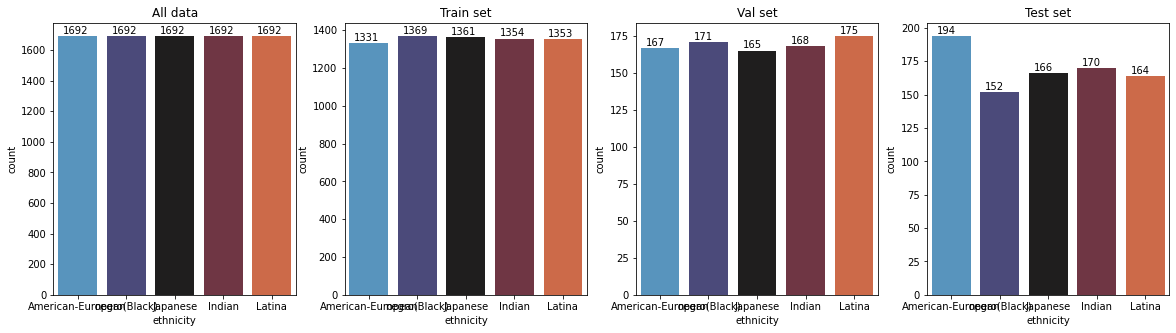

In [65]:
plt.figure(figsize=(20,5))
plt.subplot(141)
ax = sns.countplot(x= y['ethnicity'], palette="icefire")
plt.xticks(ticks=labels, labels=label_ethnicity)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01*p.get_height()))
plt.title('All data')

plt.subplot(142)
ax = sns.countplot(x= y_train['ethnicity'], palette="icefire")
plt.xticks(ticks=labels, labels=label_ethnicity)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01*p.get_height()))
plt.title('Train set')

plt.subplot(143)
ax = sns.countplot(x= y_val['ethnicity'], palette="icefire")
plt.xticks(ticks=labels,labels=label_ethnicity)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01*p.get_height()))
plt.title('Val set')

plt.subplot(144)
ax = sns.countplot(x= y_test['ethnicity'], palette="icefire")
plt.xticks(ticks=labels,labels=label_ethnicity)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01*p.get_height()))
plt.title('Test set')

plt.show()

# Image Overview

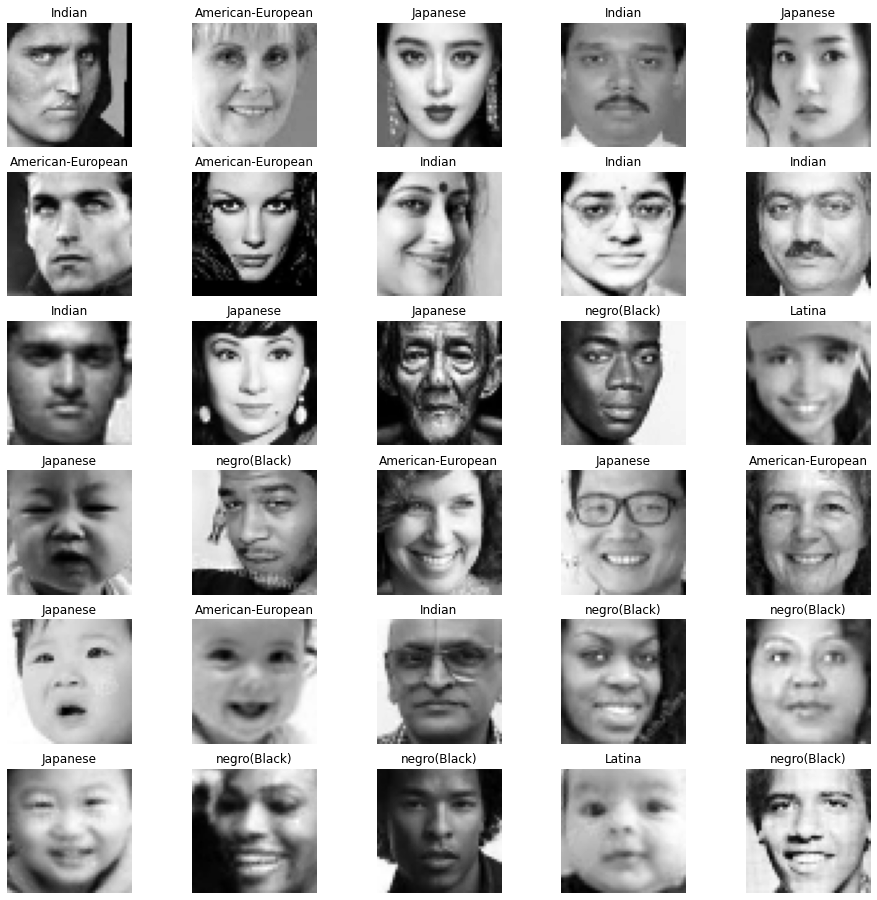

In [66]:
plt.figure(figsize=(16,16))
for i in range(0,30) :
    plt.subplot(6,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[i].reshape(48, 48), cmap='gray')
    ethni = label_ethnicity[int(np.array(y_train['ethnicity'])[i])]
    plt.title('%s' % (ethni))

#### Treatment of the format of the test, validation & training set .. convert the shape of them to 4D (samples, width, height, channels)

In [67]:
image_shape = (48, 48,1)

X_train = X_train.reshape(X_train.shape[0], *image_shape)
X_val = X_val.reshape(X_val.shape[0],*image_shape)
X_test= X_test.reshape(X_test.shape[0], *image_shape)

# Building CNN Model

Creation of a convolutional neural network **model** with layers:

* **Convolutional** with 32 3x3 filters (**INPUT**)
* **Maxpooling** to reduce the resolution of the convolution images by half
* **BatchNormalization** to normalize data
* **Convolutional** with 64 3x3 filters
* **Maxpooling** to reduce the resolution of the convolution images by half
* **BatchNormalization** to normalize data
* **Convolutional** with 64 3x3 filters
* **Maxpooling** to reduce the resolution of the convolution images by half
* **Flattening** of the convolutional layers to make a single image again
* **Dense Layer** to process the weight of each pixel of the flat image
* **Dropout** to normalize the weights of convolutional neurons with 0.2
* **Dense Layer** with 2 neurons (**OUTPUT**)

In [69]:
ethnicity_model = Sequential([ Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)),
                      MaxPooling2D(pool_size=(2, 2)),

                      BatchNormalization(),
                      Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"),
                      MaxPooling2D(pool_size=(2, 2)),
                      
                      BatchNormalization(),
                      Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"),
                      MaxPooling2D(pool_size=(2, 2)),

                      Flatten(),
                      Dense(256, activation='relu'),
                      Dropout(0.5),
                      Dense(5, activation= 'softmax')

                      ]) 
optimizer= tf.keras.optimizers.Adagrad(learning_rate= 0.001)
ethnicity_model.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

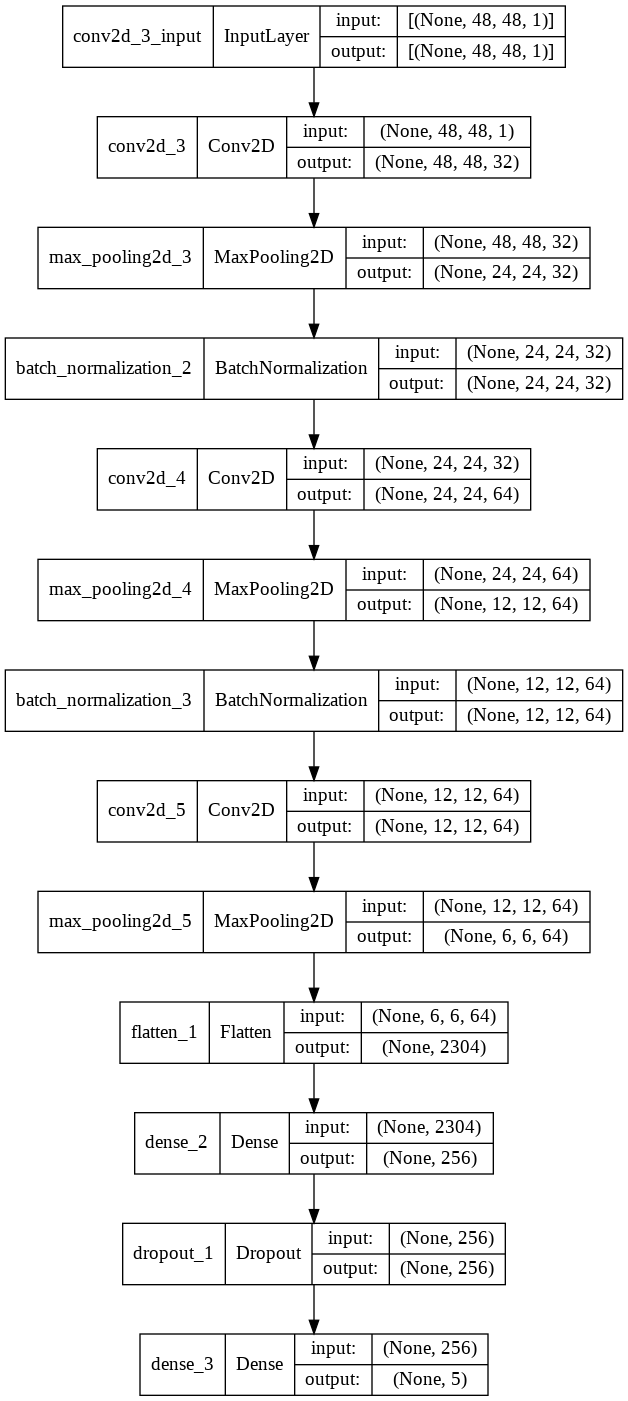

In [70]:
plot_model(ethnicity_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after `number` of epochs and `val_loss` value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

**ModelCheckpoint**

to save the best training model 

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  patience=50, mode='min') 

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
mc = ModelCheckpoint('/content/drive/MyDrive/GP/Adagrad_test_ethnicity_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

### **Gender** Training
______

In [71]:
y_ethni_train = np.array(y_train['ethnicity'])
y_ethni_val = np.array(y_val['ethnicity'])
y_ethni_test= np.array(y_test['ethnicity'])

In [ ]:
callback= [early_stopping, mc]
history_ethnicity = ethnicity_model.fit(X_train, y_ethni_train,
                                        validation_data=(X_val, y_ethni_val),
                                        epochs=3000, batch_size=370, verbose=1,
                                        callbacks = callback)

Epoch 1/3000
18/19 [===========================>..] - ETA: 0s - loss: 2.0717 - accuracy: 0.2335
Epoch 00001: val_loss improved from inf to 1.60719, saving model to /content/drive/MyDrive/GP/Adagrad2_test_ethnicity_model.h5
19/19 [==============================] - 3s 102ms/step - loss: 2.0689 - accuracy: 0.2343 - val_loss: 1.6072 - val_accuracy: 0.2092
Epoch 2/3000
18/19 [===========================>..] - ETA: 0s - loss: 1.7063 - accuracy: 0.2949
Epoch 00002: val_loss improved from 1.60719 to 1.60460, saving model to /content/drive/MyDrive/GP/Adagrad2_test_ethnicity_model.h5
19/19 [==============================] - 1s 64ms/step - loss: 1.7054 - accuracy: 0.2952 - val_loss: 1.6046 - val_accuracy: 0.2423
Epoch 3/3000
18/19 [===========================>..] - ETA: 0s - loss: 1.5794 - accuracy: 0.3323
Epoch 00003: val_loss improved from 1.60460 to 1.60205, saving model to /content/drive/MyDrive/GP/Adagrad2_test_ethnicity_model.h5
19/19 [==============================] - 1s 63ms/step - loss: 

In [72]:
ethnicity_model = load_model('/content/drive/MyDrive/GP/Adagrad_test_ethnicity_model.h5')

### Evaluate the **Ethnicity_Model**
- Training and validation curves

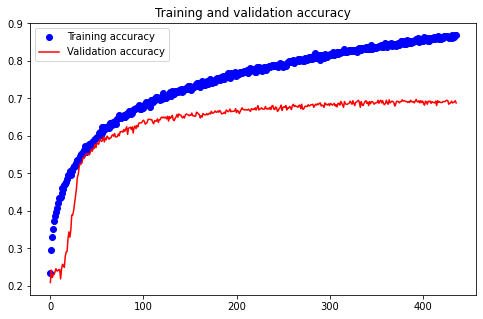

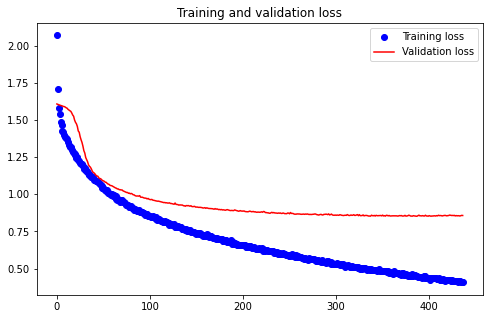

In [ ]:
accuracy = history_ethnicity.history['accuracy']
val_accuracy = history_ethnicity.history['val_accuracy']
loss = history_ethnicity.history['loss']
val_loss = history_ethnicity.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, val_accuracy, 'r')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.figure(figsize=(8, 5))

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')
plt.legend(['Training loss', 'Validation loss' ])
plt.show()

## Accuracy & loss of ***Training***

In [73]:
loss, acc = ethnicity_model.evaluate(X_train, y_ethni_train, verbose=0)
print('Train loss: {}'.format(loss))
print('Train Accuracy: {}'.format(acc))

Train loss: 0.3826296031475067
Train Accuracy: 0.9020389914512634


## Accuracy & loss of ***Validation***

In [74]:
loss, acc = ethnicity_model.evaluate(X_val, y_ethni_val, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.834579348564148
Test Accuracy: 0.6926714181900024


## Accuracy & loss of ***Testing***

In [75]:
loss, acc = ethnicity_model.evaluate(X_test, y_ethni_test, verbose=0)
print('Final_Test loss: {}'.format(loss))
print('Final_Test Accuracy: {}'.format(acc))

Final_Test loss: 0.8140722513198853
Final_Test Accuracy: 0.6973995566368103


# Prediction Images Overview

## ***Test*** Prediction

In [76]:
predict_x = ethnicity_model.predict(X_test) 
y_ethnicity_test_predict = np.argmax(predict_x,axis=1)

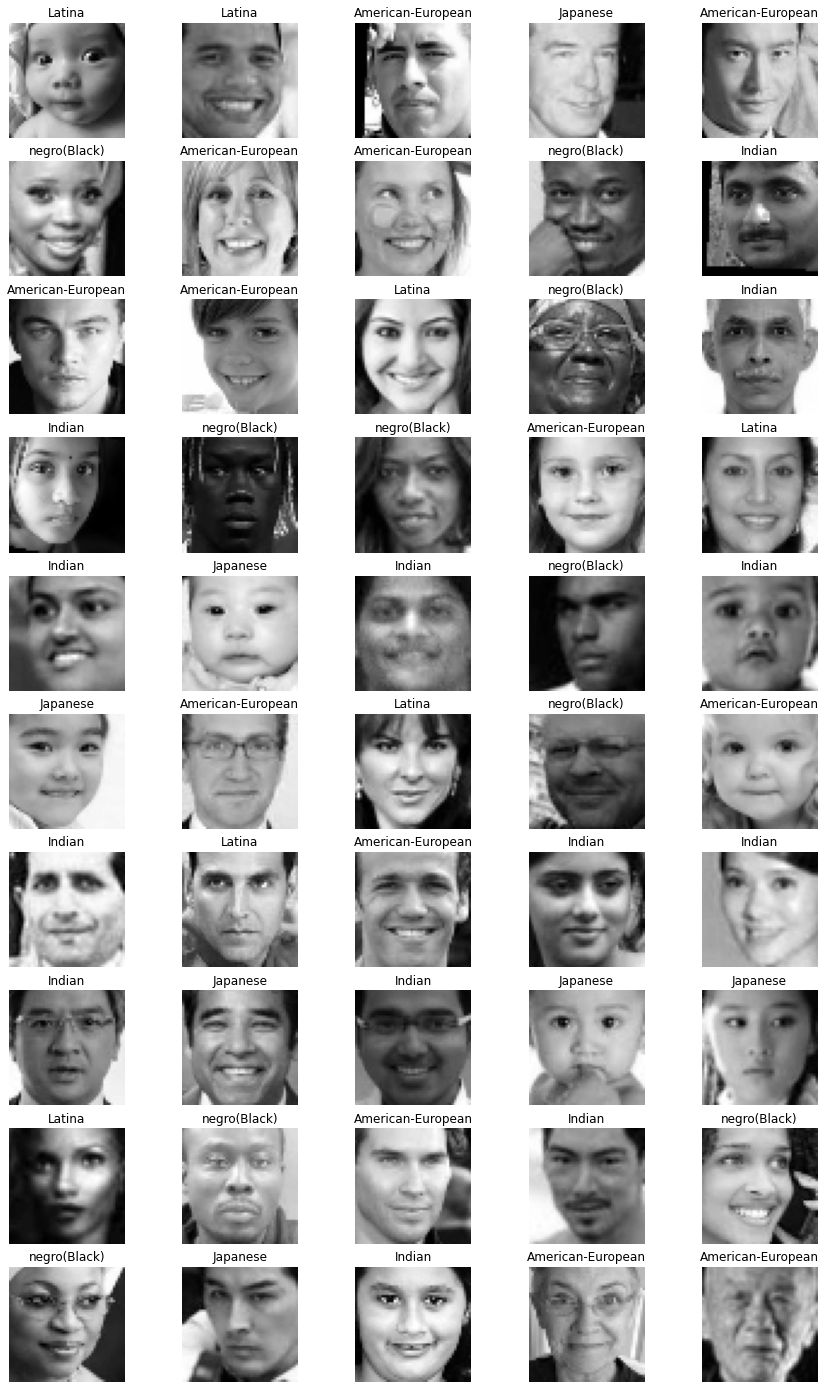

In [77]:
plt.figure(figsize=(15,25))
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (i<51):
        plt.subplot(10,5,i)
        plt.axis('off')
        plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
        ethn = label_ethnicity[int(y_ethnicity_test_predict[i])]
        plt.title('%s' % (ethn))
        i+=1

## ***Train*** Prediction

In [78]:
predict_x = ethnicity_model.predict(X_train) 
y_ethnicity_train_predict = np.argmax(predict_x,axis=1)

## Train ***Confusion Matrix***:

Text(50.99999999999999, 0.5, 'Real')

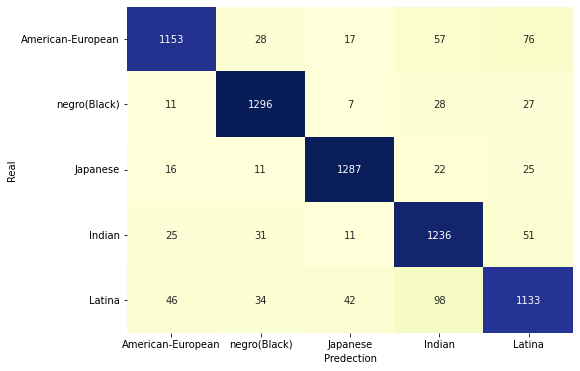

In [79]:
label_ethnicity = [ 'American-European', 'negro(Black)', 'Japanese', 'Indian', 'Latina']

cmat = confusion_matrix(y_ethni_train, y_ethnicity_train_predict, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=label_ethnicity, yticklabels=label_ethnicity);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Train*** Report

In [80]:
print(classification_report(y_ethni_train, y_ethnicity_train_predict))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1331
           1       0.93      0.95      0.94      1369
           2       0.94      0.95      0.94      1361
           3       0.86      0.91      0.88      1354
           4       0.86      0.84      0.85      1353

    accuracy                           0.90      6768
   macro avg       0.90      0.90      0.90      6768
weighted avg       0.90      0.90      0.90      6768



_____________________________________
_____________________________________

## ***Validation*** Prediction

In [82]:
predict_x = ethnicity_model.predict(X_val) 
y_ethnicity_val_predict = np.argmax(predict_x,axis=1)

## Validation ***Confusion Matrix***:

Text(50.99999999999999, 0.5, 'Real')

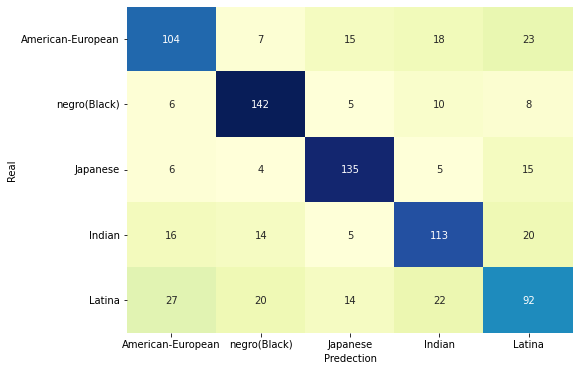

In [83]:
cmat = confusion_matrix(y_ethni_val, y_ethnicity_val_predict, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=label_ethnicity, yticklabels=label_ethnicity);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Validation*** Report

In [84]:
print(classification_report(y_ethni_val, y_ethnicity_val_predict))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       167
           1       0.76      0.83      0.79       171
           2       0.78      0.82      0.80       165
           3       0.67      0.67      0.67       168
           4       0.58      0.53      0.55       175

    accuracy                           0.69       846
   macro avg       0.69      0.69      0.69       846
weighted avg       0.69      0.69      0.69       846



_____________________________________
_____________________________________

## Test ***Confusion Matrix***:

Text(50.99999999999999, 0.5, 'Real')

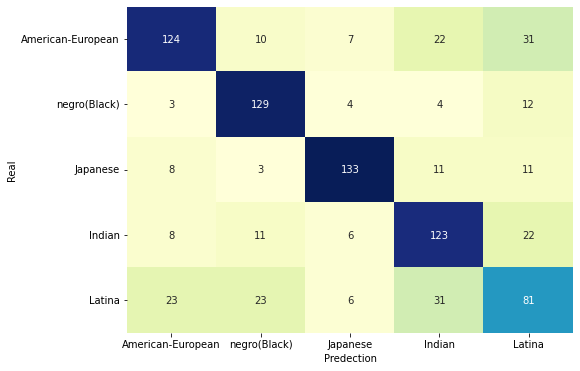

In [85]:
cmat = confusion_matrix(y_ethni_test, y_ethnicity_test_predict, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=label_ethnicity, yticklabels=label_ethnicity);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Test*** Report

In [86]:
print(classification_report(y_ethni_test, y_ethnicity_test_predict))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       194
           1       0.73      0.85      0.79       152
           2       0.85      0.80      0.83       166
           3       0.64      0.72      0.68       170
           4       0.52      0.49      0.50       164

    accuracy                           0.70       846
   macro avg       0.70      0.70      0.70       846
weighted avg       0.70      0.70      0.70       846

